In [ ]:
import torch
import numpy as np
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32)),
    T.Normalize([0.5], [0.5])
])

train_set = MNIST('~/datasets/mnist', transform=transform, download=True, train=True)
test_set = MNIST('~/datasets/mnist',  transform=transform, train=False)

## 1. AutoEncoder

![](https://www.mdpi.com/information/information-10-00122/article_deploy/html/images/information-10-00122-g003.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4),
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
        )

    def forward(self, x):
        return self.net(x)


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
x = torch.randn(1, 1, 32, 32)
enc = Encoder()
dec = Decoder()

print(f'Encoder params: {sum(param.numel() for param in enc.parameters())}')
print(f'Decoder params: {sum(param.numel() for param in dec.parameters())}')

Encoder params: 195712
Decoder params: 195585


In [ ]:
z = enc(x)
z.shape

torch.Size([1, 128, 1, 1])

In [ ]:
x_rec = dec(z)
x_rec.shape

torch.Size([1, 1, 32, 32])

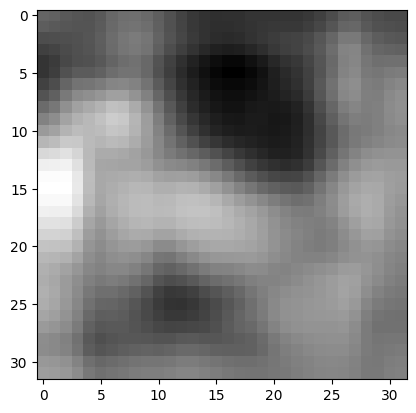

In [ ]:
plt.imshow((x_rec[0, 0].detach() + 1) / 2, cmap='gray')

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=4, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, pin_memory=True, num_workers=4)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
ae = AutoEncoder().to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    ae.train()
    train_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        reconstructed = ae(images)
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.shape[0]

    ae.eval()
    test_loss = 0.0
    with torch.inference_mode():
        for images, _ in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
            images = images.to(device)
            reconstructed = ae(images)
            loss = criterion(reconstructed, images)
            test_loss += loss.item() * images.shape[0]

    clear_output()
    train_loss /= len(train_set)
    test_loss /= len(test_set)
    print(f'Epoch {epoch}/{num_epochs}: train loss: {train_loss:.3f}, test loss: {test_loss:.3f}')

Epoch 20/20: train loss: 0.019, test loss: 0.019


In [ ]:
image = test_set[71][0].unsqueeze(0)

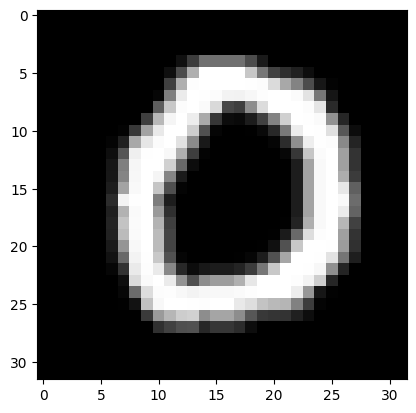

In [ ]:
plt.imshow((image[0, 0] + 1) / 2, cmap='gray')

In [ ]:
ae = ae.to('cpu')

with torch.no_grad():
    rec_image = ae(image)

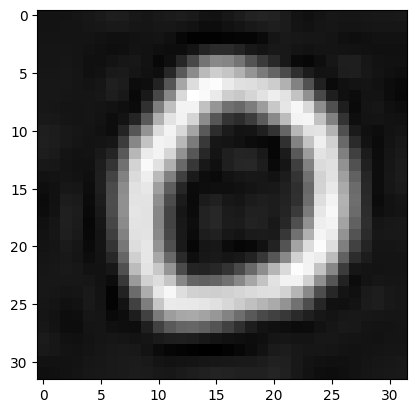

In [ ]:
plt.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')

Autoencoder does not work as a generative model :(

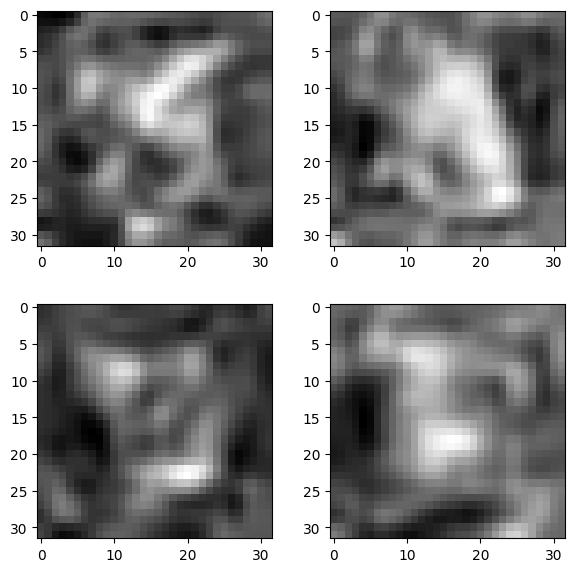

In [ ]:
z = ae.encode(image)
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
plt.tight_layout()

for ax in axs.flatten():
    with torch.no_grad():
        z = torch.randn_like(z)
        rec_image = ae.decode(z)

    ax.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')

plt.show()

## 2. Variational Autoencoder

![](https://machinelearningmastery.ru/img/0-641830-557317.png)

$$
\mathcal{L}_{VAE} = \underbrace{\mathbb{E}_{q_{\phi}(z|x)} \Big[\log p_{\theta}(x|z)\Big]}_{\text{reconstruction loss}} + \underbrace{KL\big(q_{\phi}(z|x) \big|\big|p(z)\big)}_{\text{latent regularization}}
$$

$$
\log p_{\theta}(x|z) \propto \frac{1}{2} \Big\|x - \mu_{\theta}(z)\Big\|_2^2
$$

$$
q_{\phi}(z|x) = \mathcal{N}\Big(z\Big|\mu_{\phi}(x), \text{diag}(\sigma_{\phi}^2(x))\Big) \Rightarrow KL\big(q_{\phi}(z|x) \big|\big|p(z)\big) = -\frac{d}{2} + \frac{1}{2}\sum_{i=1}^d \Big( -\log \sigma_i^2 + \sigma_i^2 + \mu_i^2\Big)
$$

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 2 * 128, kernel_size=4),
        )

    def forward(self, x):
        z = self.net(x)
        z_mu, z_log_sigma_sq = z[:, :128], z[:, 128:]
        return z_mu, z_log_sigma_sq


class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=5, padding=2),
            nn.Upsample(scale_factor=2, mode='bilinear'),
        )

    def forward(self, z):
        x_mu = self.net(z)
        return x_mu


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, log_sigma_sq, eps):
        return mu + torch.exp(0.5 * log_sigma_sq) * eps

    def forward(self, x):
        z_mu, z_log_sigma_sq = self.encode(x)
        eps = torch.randn_like(z_mu)
        z = self.reparameterize(z_mu, z_log_sigma_sq, eps)
        x_mu = self.decode(z)
        return z_mu, z_log_sigma_sq, x_mu


class VAELoss(nn.Module):
    def forward(self, x, z_mu, z_log_sigma_sq, x_mu):
        z_sigma_sq = torch.exp(z_log_sigma_sq)
        rec_loss = ((x - x_mu).square()).sum() / x.shape[0]
        rec_loss = 0.5 * rec_loss

        kl_loss = (-1 + -z_log_sigma_sq + z_sigma_sq + z_mu.square()).sum() / x.shape[0]
        kl_loss = 0.5 * kl_loss
        return rec_loss + kl_loss, rec_loss, kl_loss

In [ ]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)
criterion = VAELoss()

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    vae.train()
    train_loss, train_rec, train_kl = 0.0, 0.0, 0.0
    for images, _ in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        out = vae(images)
        loss, rec, kl = criterion(images, *out)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.shape[0]
        train_rec += rec.item() * images.shape[0]
        train_kl += kl.item() * images.shape[0]

    vae.eval()
    test_loss, test_rec, test_kl = 0.0, 0.0, 0.0
    with torch.inference_mode():
        for images, _ in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
            images = images.to(device)
            out = vae(images)
            loss, rec, kl = criterion(images, *out)
            test_loss += loss.item() * images.shape[0]
            test_rec += rec.item() * images.shape[0]
            test_kl += kl.item() * images.shape[0]

    clear_output()
    train_loss /= len(train_set)
    test_loss /= len(test_set)
    train_rec /= len(train_set)
    test_rec /= len(test_set)
    train_kl /= len(train_set)
    test_kl /= len(test_set)

    print(
        f'Epoch {epoch}/{num_epochs}: train loss: {train_loss:.3f}, '
        f'train rec: {train_rec:.3f}, train kl: {train_kl:.3f}\n'
        f'\t\ttest loss: {test_loss:.3f}, test rec: {test_rec:.3f}, test kl: {test_kl:.3f}'
    )

Epoch 20/20: train loss: 43.635, train rec: 26.621, train kl: 17.013
		test loss: 43.709, test rec: 26.708, test kl: 17.001


In [ ]:
image = test_set[77][0].unsqueeze(0)

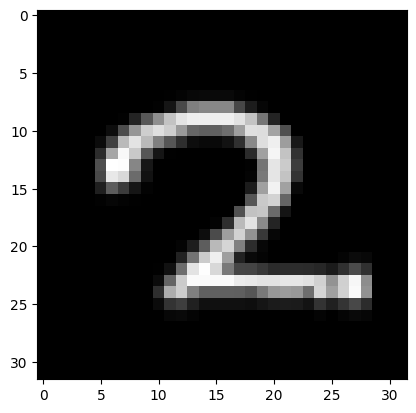

In [ ]:
plt.imshow((image[0, 0] + 1) / 2, cmap='gray')

In [ ]:
vae = vae.to('cpu')
noisy = True

with torch.no_grad():
    z_mu, z_log_sigma_sq = vae.encode(image)
    eps = torch.randn_like(z_mu) if noisy else torch.zeros_like(z_mu)

    z = vae.reparameterize(z_mu, z_log_sigma_sq, eps)
    rec_image = vae.decode(z)

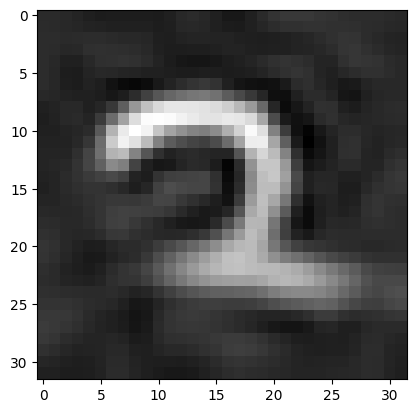

In [ ]:
plt.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')

Unconditional sampling (from standard normal -- prior for latents)

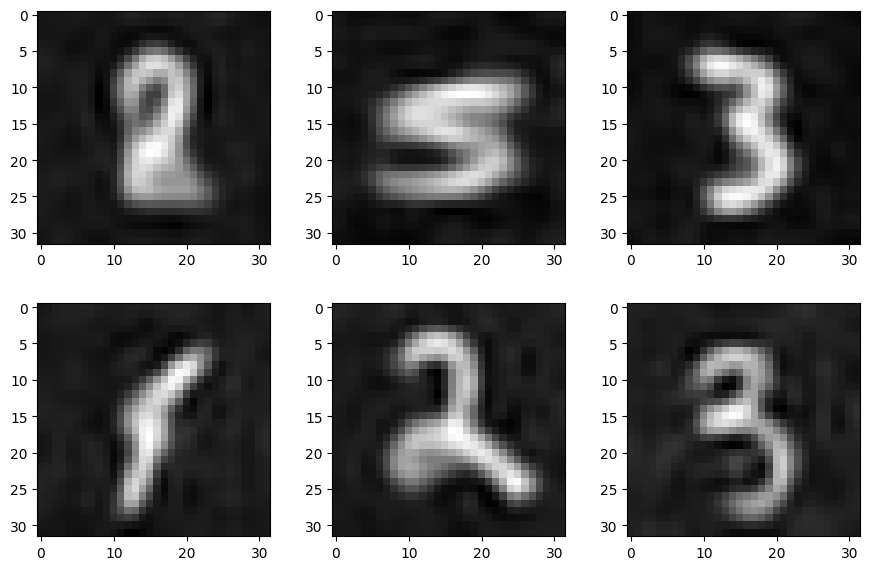

In [ ]:
z_mu, z_log_sigma_sq = vae.encode(image)
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
plt.tight_layout()

for ax in axs.flatten():
    with torch.no_grad():
        z = torch.randn_like(z_mu)
        rec_image = vae.decode(z)

    ax.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')

plt.show()

Conditional sampling (from latents posterior)

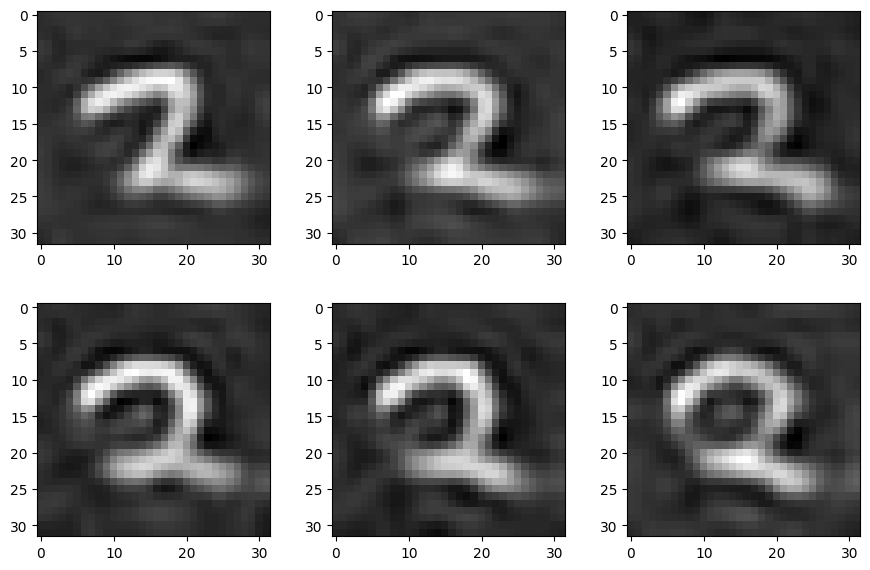

In [ ]:
z_mu, z_log_sigma_sq = vae.encode(image)
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
plt.tight_layout()

for ax in axs.flatten():
    with torch.no_grad():
        eps = torch.randn_like(z_mu)
        z = vae.reparameterize(z_mu, z_log_sigma_sq, eps)
        rec_image = vae.decode(z)

    ax.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')

plt.show()

In [ ]:
ae_latents = []

ae = ae.to(device)
with torch.inference_mode():
    for images, _ in tqdm(test_loader, desc=f'Generating latents'):
        images = images.to(device)
        latents = ae.encode(images)
        ae_latents.append(latents.cpu())

ae_latents = torch.cat(ae_latents, dim=0).squeeze().numpy()

Generating latents:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
vae_latents = []
vae_log_sigma_sq = []

vae = vae.to(device)
with torch.inference_mode():
    for images, _ in tqdm(test_loader, desc=f'Generating latents'):
        images = images.to(device)
        latents, log_sigma_sq = vae.encode(images)
        vae_latents.append(latents.cpu())
        vae_log_sigma_sq.append(log_sigma_sq.cpu())

vae_latents = torch.cat(vae_latents, dim=0).squeeze().numpy()
vae_log_sigma_sq = torch.cat(vae_log_sigma_sq, dim=0).squeeze().numpy()

Generating latents:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
ae_embeds = TSNE(verbose=2).fit_transform(ae_latents)

/home/isadrtdinov/anaconda3/envs/huggingface/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/isadrtdinov/anaconda3/envs/huggingface/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.422622
[t-SNE] Computed conditional probabilities in 0.490s
[t-SNE] Iteration 50: error = 97.1993713, gradient norm = 0.0021546 (50 iterations in 1.604s)
[t-SNE] It

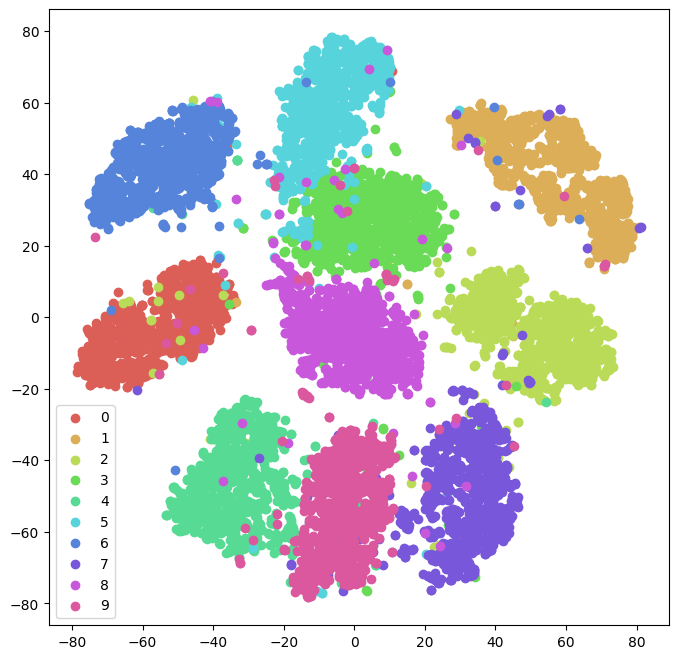

In [ ]:
plt.figure(figsize=(8, 8))
colors = sns.color_palette('hls', 10)
targets = test_set.targets.numpy()

for i, color in enumerate(colors):
    plt.scatter(ae_embeds[targets == i, 0], ae_embeds[targets == i, 1], color=color, label=str(i))

plt.legend()

In [ ]:
vae_embeds = TSNE(verbose=2).fit_transform(vae_latents)

/home/isadrtdinov/anaconda3/envs/huggingface/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/isadrtdinov/anaconda3/envs/huggingface/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 1.948s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.929891
[t-SNE] Computed conditional probabilities in 0.439s
[t-SNE] Iteration 50: error = 97.5544205, gradient norm = 0.0009014 (50 iterations in 1.580s)
[t-SNE] It

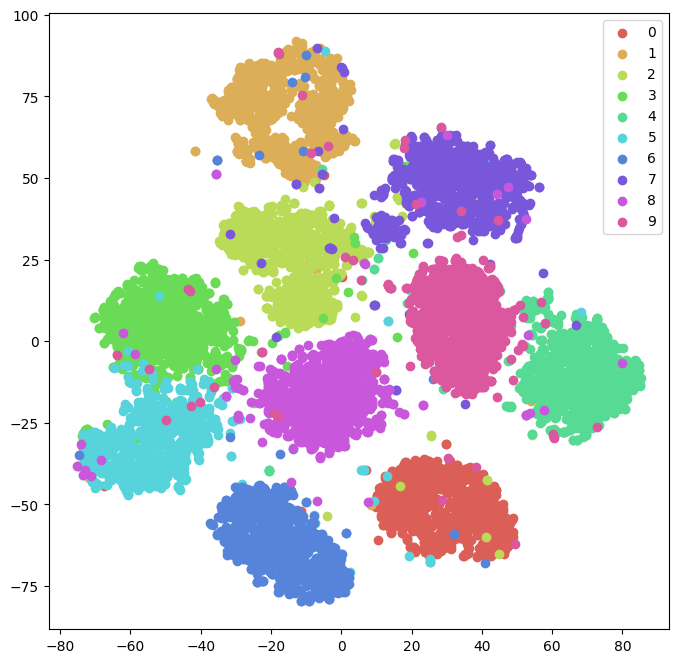

In [ ]:
plt.figure(figsize=(8, 8))
colors = sns.color_palette('hls', 10)
targets = test_set.targets.numpy()

for i, color in enumerate(colors):
    plt.scatter(vae_embeds[targets == i, 0], vae_embeds[targets == i, 1], color=color, label=str(i))

plt.legend()

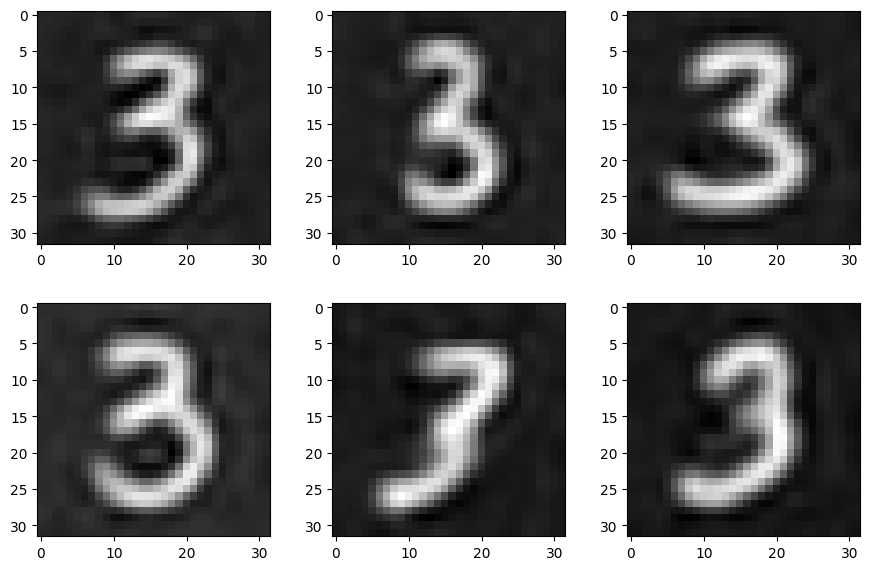

In [ ]:
i = 3

z_mu = torch.from_numpy(vae_latents[targets == i].mean(0).reshape(1, -1, 1, 1))
z_log_sigma_sq = torch.from_numpy(np.log(vae_latents[targets == i].var(0).reshape(1, -1, 1, 1)))

fig, axs = plt.subplots(2, 3, figsize=(9, 6))
plt.tight_layout()

vae = vae.to('cpu')
for ax in axs.flatten():
    with torch.no_grad():
        eps = torch.randn_like(z_mu)
        z = vae.reparameterize(z_mu, z_log_sigma_sq, eps)
        rec_image = vae.decode(z)

    ax.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')

plt.show()

In [ ]:
image1, image2 = test_set[10][0].unsqueeze(0), test_set[77][0].unsqueeze(0)

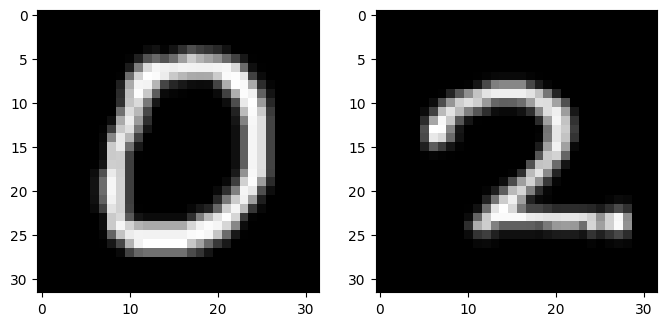

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow((image1[0, 0] + 1) / 2, cmap='gray')
axs[1].imshow((image2[0, 0] + 1) / 2, cmap='gray')

In [ ]:
z_mu1, _ = vae.encode(image1)
z_mu2, _ = vae.encode(image2)

alphas = np.linspace(0, 1, 15)
images = []

with torch.inference_mode():
    for alpha in alphas:
        z_mu = z_mu1 * (1 - alpha) + z_mu2 * alpha
        rec_image = vae.decode(z_mu)
        images.append(rec_image)

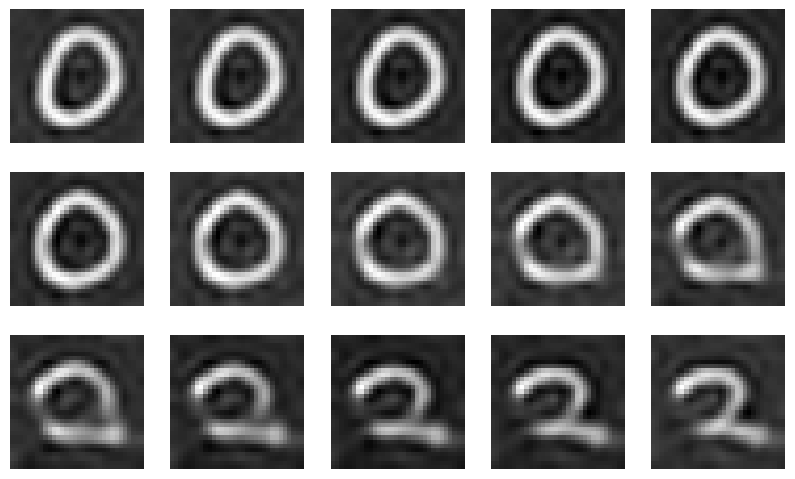

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for rec_image, ax in zip(images, axs.flatten()):
    ax.imshow((rec_image[0, 0] + 1) / 2, cmap='gray')
    ax.axis('off')